# Distance Decorrelation

The page [2007.14400](https://arxiv.org/abs/2007.14400) uses a distance decorrelation to solve the problem we are having. It is non-trival to calculate, however (at least for me), so this is a notebook about calculating it.

From the paper the calculation is the following:

$
dCov^2 = <|f-f'|\times|g-g'|> - <|f-f'|>\times<|g-g'|> - 2<|f-f'|\times|g-g''|>
$

where:

- $f,f'$ are drawn from the first variable distribution
- $g,g',g''$ are drwan from the second variable distribution.

If one things of these in terms of sums, then $f-f'$ is $f_i - f_j$ for all $i,j$. And $g-g''$ is for all $i,k$ - that expression is teh tripple.

And the distance coorelation is:

$
disCo^2 = \frac{dCor^2[f,g]}{dCor[f,f]dCor[g,g]}
$

## Setup

In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt

In [3]:
n_samples = 100

## Exploring

Here we figure out how to build up a function that will calculate this. First, lets get two distributions, $f$ and $g$ for this. We'll make them simple gaussians with slightly different means and widths

In [4]:
f = np.random.normal(loc=1.0, size=n_samples)
g = np.random.normal(loc=1.5, size=n_samples)

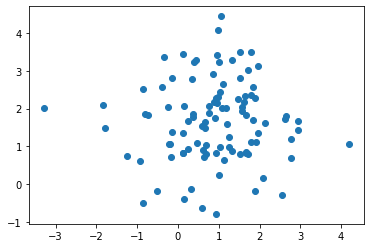

In [5]:
plt.scatter(f,g)

### $<f-f'>$

This is like the [`numpy.outter`](https://numpy.org/doc/stable/reference/generated/numpy.ufunc.outer.html#numpy.ufunc.outer) call.

In [6]:
A = [1, 2, 3]
B = [2, 3, 4]

In [7]:
rows = np.subtract.outer(A, B)
rows

array([[-1, -2, -3],
       [ 0, -1, -2],
       [ 1,  0, -1]])

This does `A[0] - B`, then `A[1] - B`, and then `A[2] - B`. Each elemnt is a $f_i - f_j$ - so we just need the mean now, which is the expectation value:

In [8]:
np.mean(rows)

-1.0

Putting it all together:

In [9]:
np.mean(np.subtract.outer(A,B))

-1.0

And for the initial distributions:

In [10]:
def single_0(a):
    return np.mean(np.abs(np.subtract.outer(a,a)))

single_0(A)

0.8888888888888888

What about for the same objects, which is $f-f'$?

In [11]:
np.mean(np.subtract.outer(A,A))

0.0

In [12]:
single_0(f)

1.2220886466457501

In [13]:
single_0(g)

1.1980268650118435

Those really small numbers make me nervous - we will have to divide by them in the end, won't we?

Lets try with argmesh as a check - that will explicitly do the calculation.

In [14]:
A_all_combo, B_all_combo = np.meshgrid(np.arange(0,len(A)),np.arange(0,len(B)), sparse=False)
A_all_combo, B_all_combo

(array([[0, 1, 2],
        [0, 1, 2],
        [0, 1, 2]]), array([[0, 0, 0],
        [1, 1, 1],
        [2, 2, 2]]))

In [15]:
np.take(A, A_all_combo), np.take(B, B_all_combo)

(array([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]]), array([[2, 2, 2],
        [3, 3, 3],
        [4, 4, 4]]))

In [16]:
def single_1(a):
    all_combo_i, all_combo_j = np.meshgrid(np.arange(0,len(a)), np.arange(0,len(a)), sparse=True)
    a_i = np.take(a, all_combo_i)
    a_j = np.take(a, all_combo_j)
    return np.mean(np.abs(a_i - a_j))

single_1(A), single_1(f), single_1(g)

(0.8888888888888888, 1.2220886466457501, 1.1980268650118435)

We'll use the `outer` form as it uses a lot less memory than the `meshgrid` form.

In [17]:
single = single_0

### $<|f-f'|\times|g-g'|>$

This is hard because we have to keep the same combination going here. So outer, as we were using above, doesn't make as much sense. However, we can take advantage of the fact that the way `outer` works the are the same.

In [19]:
A_sub = np.subtract.outer(A,A)
B_sub = np.subtract.outer(B,B)
A_sub, B_sub

(array([[ 0, -1, -2],
        [ 1,  0, -1],
        [ 2,  1,  0]]), array([[ 0, -1, -2],
        [ 1,  0, -1],
        [ 2,  1,  0]]))

In [20]:
A_sub*B_sub

array([[0, 1, 4],
       [1, 0, 1],
       [4, 1, 0]])

In [21]:
np.mean(np.abs(A_sub*B_sub))

1.3333333333333333

In [22]:
def joint_0(a, b):
    return np.mean(np.abs(np.subtract.outer(a,a))*np.abs(np.subtract.outer(b,b)))

joint_0(A, B)

1.3333333333333333

In [23]:
joint_0(f,f), joint_0(g,g)

(2.518346813616607, 2.2644559930511523)

In [24]:
joint_0(f,g),joint_0(g,f)

(1.4054586514096643, 1.4054586514096643)

Lets try with `meshgrid` to see if this works out the same.

In [26]:
def joint_1(a, b):
    all_combo_i, all_combo_j = np.meshgrid(np.arange(0,len(a)), np.arange(0,len(a)), sparse=True)
    a_i = np.take(a, all_combo_i)
    a_j = np.take(a, all_combo_j)
    b_i = np.take(b, all_combo_i)
    b_j = np.take(b, all_combo_j)
    return np.mean(np.abs((a_i - a_j))*np.abs((b_i - b_j)))

joint_1(A, B), joint_1(f,f), joint_1(g,g), joint_1(f,g), joint_1(g,f)

(1.3333333333333333,
 2.518346813616607,
 2.2644559930511523,
 1.4054586514096643,
 1.4054586514096643)

We'll use the `outer` form for now as it uses less memory.

In [27]:
joint=joint_0

### $<|f-f'|\times|g-g''|>$

This is the tripple, which is a bit more of a mess as we are dealing with a tripple, and $f$ and $g$ have to be drawn from the same thing.

Just in case it has been forgotten, `len(f) == len(g)`.

We are looking at the $\sum |f_i - f_j|\times|g_i - g_k|$

The usual `np.subtract.outer(A,A)` will give us the square matrix of all possible combinations:

In [28]:
A

[1, 2, 3]

In [29]:
np.subtract.outer(A,A)

array([[ 0, -1, -2],
       [ 1,  0, -1],
       [ 2,  1,  0]])

In [30]:
np.subtract.outer(B,B)

array([[ 0, -1, -2],
       [ 1,  0, -1],
       [ 2,  1,  0]])

If that first row for `A` is $i,j = \{11, 12, 13\}$, then it is for $i$ equal to one. So that each element of the first row needs to be multiplied by all the first row in the `B` outer. From `A` we have `[0, -1, -2]` and from `B` we have `[0, -1, -2]` so we should now get `[[0*0, -1*0, -2*0], [0*-1, -1*-1, -2*-1], [0*-2, -1*-2, -2*-2]]`. So this is like another outter. We are expecting 9 rows of three now rather than 3 rows of 3.

In [63]:
A_outer = np.subtract.outer(A,A)
B_outer = np.subtract.outer(B,B)
np.multiply.outer(A_outer[0], B_outer[0])

array([[0, 0, 0],
       [0, 1, 2],
       [0, 2, 4]])

In [51]:
def tripple_0(a, b):
    s = 0.0
    count = 0
    for i in range(len(a)):
        for j in range(len(a)):
            ad = a[i] - a[j]
            for k in range(len(a)):
                bd = b[i] - b[k]
                s += abs(ad)*abs(bd)
                count += 1

    return s/count

tripple_0(A, B), tripple_0(f,f), tripple_0(g,g), tripple_0(f,g), tripple_0(g,f)

(0.8148148148148148,
 1.789473347496697,
 1.618726275775436,
 1.429505007221833,
 1.4295050072218332)

Lets try it with mesh grid and an explicit tripple now.

In [47]:
np.meshgrid(np.arange(0,len(A)),np.arange(0,len(A)),np.arange(0,len(A)))

[array([[[0, 0, 0],
         [1, 1, 1],
         [2, 2, 2]],
 
        [[0, 0, 0],
         [1, 1, 1],
         [2, 2, 2]],
 
        [[0, 0, 0],
         [1, 1, 1],
         [2, 2, 2]]]), array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]],
 
        [[2, 2, 2],
         [2, 2, 2],
         [2, 2, 2]]]), array([[[0, 1, 2],
         [0, 1, 2],
         [0, 1, 2]],
 
        [[0, 1, 2],
         [0, 1, 2],
         [0, 1, 2]],
 
        [[0, 1, 2],
         [0, 1, 2],
         [0, 1, 2]]])]

In [50]:
def tripple_1(a, b):
    all_combo_i, all_combo_j, all_combo_k = np.meshgrid(np.arange(0,len(a)), np.arange(0,len(a)), np.arange(0,len(a)), sparse=True)
    a_i = np.take(a, all_combo_i)
    a_j = np.take(a, all_combo_j)
    b_i = np.take(b, all_combo_i)
    b_k = np.take(b, all_combo_k)
    return np.mean(np.abs((a_i - a_j))*np.abs((b_i - b_k)))

tripple_1(A, B), tripple_1(f,f), tripple_1(g,g), tripple_1(f,g), tripple_1(g,f)

(0.8148148148148148,
 1.7894733474965687,
 1.6187262757754852,
 1.429505007221774,
 1.429505007221774)

We'll need something better - `tripple_1` works, but it also costs too much memory.

1. We can calculate $a-a'$ and $b-b'$ no problem. The times is wierd, We want to multiply all the rows in $a-a'$ by each row in $b-b'$ - so we expect that many more rows we have to sum up.

In [62]:
A_outer = np.subtract.outer(A,A)
B_outer = np.subtract.outer(B,B)

In [65]:
np.multiply.outer(A_outer[0], B_outer[0])

array([[0, 0, 0],
       [0, 1, 2],
       [0, 2, 4]])

In [76]:
def tripple_2(a,b):
    a_outer = np.abs(np.subtract.outer(a,a))
    b_outer = np.abs(np.subtract.outer(b,b))
    s = 0.0
    for i in range(len(a)):
        m = np.multiply.outer(a_outer[i], b_outer[i])
        s += np.sum(m)
    return s / (len(a)*len(a)*len(a))

tripple_1(A, B), tripple_1(f,f), tripple_1(g,g), tripple_1(f,g), tripple_1(g,f)

(0.8148148148148148,
 1.7894733474965687,
 1.6187262757754852,
 1.429505007221774,
 1.429505007221774)

Use `tripple_2` because we don't have the memory for the meshgrid, and two only has one python level loop

In [77]:
tripple = tripple_2

### Distance Covarience

Now we can do the covar 2

In [78]:
def dcov2(a,b):
    return joint(a,b) + single(a)*single(b) - 2*tripple(a,b)

dcov2(A,B)

0.4938271604938269

In [79]:
dcov2(f,g)

0.010543667073692031

## Distance Coherrence

In [80]:
def dis_co2(a,b):
    return dcov2(a,b)/(dcov2(a,a)*dcov2(b,b))

dis_co2(A,B)

2.025000000000001

In [81]:
dis_co2(f,g)

0.05268729545256559

Lets see how it behaves when we have a correlated distribution

In [82]:
ar = np.random.multivariate_normal((1.0, 1.0), ((1.0, 0.5), (0.5, 1.0)), 1000)
ar_a = ar[:,0]
ar_b = ar[:,1]

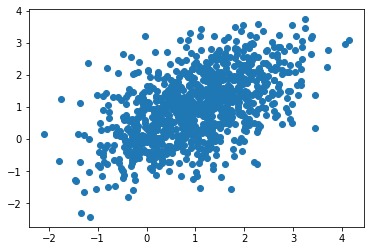

In [83]:
plt.scatter(ar_a, ar_b)

In [84]:
def dist_co_for_correlation(c):
    ar = np.random.multivariate_normal((1.0, 1.0), ((1.0, c), (c, 1.0)), 1000)
    ar_a = ar[:,0]
    ar_b = ar[:,1]
    return dis_co2(ar_a, ar_b)

In [85]:
dist_co_for_correlation(0.0)

0.006399783028605641

In [86]:
dist_co_for_correlation(0.5)

0.5371882387114135

In [87]:
dist_co_for_correlation(-0.5)

0.641436850540698

In [88]:
cor_values = np.linspace(-1.0, 1.0, 20)

In [89]:
cor_values

array([-1.        , -0.89473684, -0.78947368, -0.68421053, -0.57894737,
       -0.47368421, -0.36842105, -0.26315789, -0.15789474, -0.05263158,
        0.05263158,  0.15789474,  0.26315789,  0.36842105,  0.47368421,
        0.57894737,  0.68421053,  0.78947368,  0.89473684,  1.        ])

In [90]:
disco2_values = np.vectorize(dist_co_for_correlation)(cor_values)

In [91]:
disco2_values

array([2.18857571, 1.92590634, 1.35788625, 0.93936952, 0.73022993,
       0.50738635, 0.21978055, 0.16646018, 0.08910244, 0.00394611,
       0.00959305, 0.06862735, 0.11592862, 0.24116612, 0.35171662,
       0.74197701, 0.92293782, 1.36391642, 1.71792085, 2.44414665])

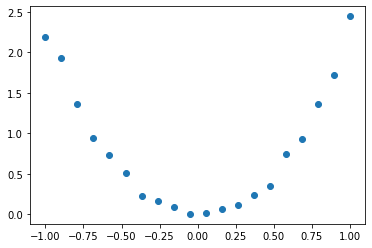

In [92]:
plt.scatter(cor_values, disco2_values)

While this appears to work - one problem is that it takes a very very long time. There is something inefficient about how this calculation is being done in the numpy world. Given the next step is to convert to pytorch I'm not sure how worth it is to understanding this carefully.

## Test previous results

Notbook 05 produced some data. Lets see how this works on that.

In [93]:
d_05 = np.load('../data/05-uncorrelated.npy')

In [94]:
d_05

array([[0.39854088, 0.41779825],
       [0.26498005, 0.21531308],
       [0.5683266 , 0.55050945],
       ...,
       [0.2773594 , 0.14185959],
       [0.87566507, 0.88304293],
       [0.404407  , 0.44990236]], dtype=float32)

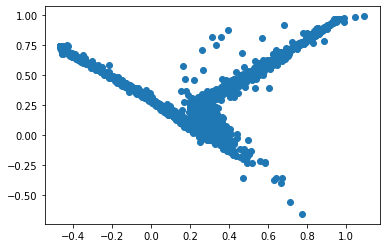

In [96]:
plt.scatter(d_05[:,0], d_05[:,1])

Calculate the pearson correlation coeff

In [97]:
def calc_r(prediction):
    mean = np.mean(prediction, axis=0)
    std_dev = np.std(prediction, axis=0)
    parts = (prediction - mean)
    sum = np.sum(parts[:,0]*parts[:,1])
    return sum / std_dev[0] / std_dev[1] / (prediction.shape[0]-1)

calc_r(d_05)

0.0615289500771248

In [98]:
dis_co2(d_05[:,0], d_05[:,1])

17.537383777642535